In [1]:
from IPython.display import display

import cv2
import ffmpeg
import numpy as np
import matplotlib.pyplot as plt

from skimage.metrics import structural_similarity as SSIM

%matplotlib inline

In [2]:
data_path = "../data/"
video_path = "ADS HG.MP4"
path = data_path + video_path

cap = cv2.VideoCapture(path)

width = int(cap.get(3))
height = int(cap.get(4))
frame_rate = cap.get(5)
num_frames = int(cap.get(7))

frames = []
idx = 0
while(cap.isOpened() and idx < num_frames):
    ret, frame = cap.read()

    if ret == True:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        idx += 1
    else:
        pass
        # print("There is some problem")

cap.release()

print("Video width = " + str(width))
print("Video height = " + str(height))
print("Frame rate = " + str(frame_rate))
print("Number of frames: " + str(num_frames))

print("Frames recieved = " + str(len(frames)))


Video width = 1920
Video height = 1080
Frame rate = 239.76023976023976
Number of frames: 5535
Frames recieved = 5535


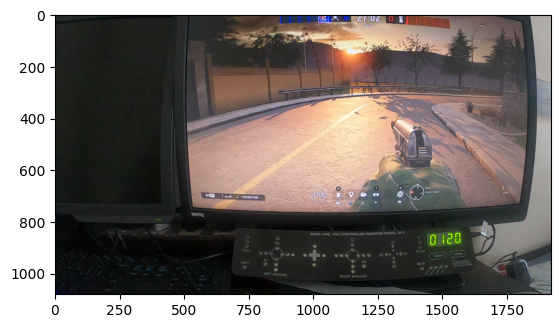

In [3]:
# Just to check the frames
temp_im = frames[5532]
plt.imshow(temp_im, cmap='gray')
plt.show()

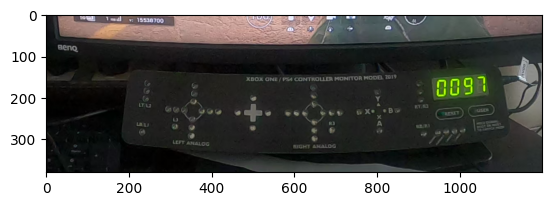

In [4]:
start_idx_x = 700
last_idx_x = 1080
start_idx_y = 500
last_idx_y = 1700

bottom_frame_set = []
for i in range(len(frames)):
    bottom_frame_set.append(frames[i][start_idx_x : last_idx_x, start_idx_y : last_idx_y])

temp_img = bottom_frame_set[0]
plt.imshow(temp_img, cmap='gray')
plt.show()

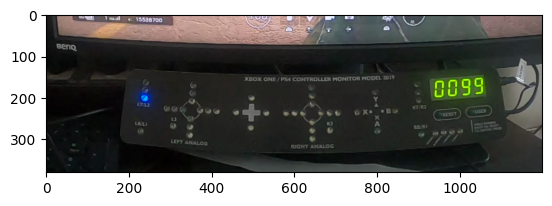

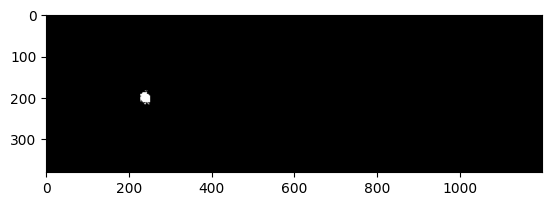

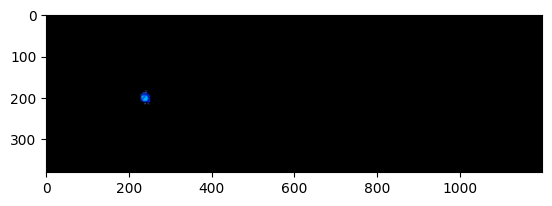

Total number of white pixels 529


In [5]:
#450 Has 1 blip
# 422 to 423 has a blip in between

# Blue detection in the bottom images
temp_img = bottom_frame_set[423]

temp_img_hsv = cv2.cvtColor(temp_img, cv2.COLOR_RGB2HSV)

lower_blue = np.array([90, 100, 140])
upper_blue = np.array([150, 255, 255])

mask = cv2.inRange(temp_img_hsv, lower_blue, upper_blue)
result = cv2.bitwise_and(temp_img, temp_img, mask = mask)

plt.imshow(temp_img, cmap='gray')
plt.show()
plt.imshow(mask, cmap='gray')
plt.show()
plt.imshow(result, cmap='gray')
plt.show()

mask = np.array(mask)
print("Total number of white pixels " + str(int(np.sum(mask)/255)))

In [6]:
#450 Has 1 blip
# 422 to 423 has a blip in between

# Blue detection in the bottom images
trigger_points = np.zeros((len(frames)))
trigger_counted = False

for i in range(len(bottom_frame_set)):
    if i % 1000 == 0:
        print("Number of frames done "+ str(i))
    temp_img = bottom_frame_set[i]

    temp_img_hsv = cv2.cvtColor(temp_img, cv2.COLOR_RGB2HSV)

    lower_blue = np.array([90, 100, 140])
    upper_blue = np.array([150, 255, 255])

    mask = cv2.inRange(temp_img_hsv, lower_blue, upper_blue)
    result = cv2.bitwise_and(temp_img, temp_img, mask = mask)
    mask = np.array(mask)
    num_white_pix = int(np.sum(mask)/255)

    if num_white_pix > 300 and trigger_counted == False:
        trigger_points[i] = 1
        trigger_counted = True
    
    if num_white_pix <= 300:
        trigger_counted = False

print("All frames considered")

trigger_loc = []
for i in range(len(trigger_points)):
    if trigger_points[i] == 1:
        trigger_loc.append(i)

print("Number of trigger locations ", len(trigger_loc))
print("All the trigger locations ", trigger_loc)

Number of frames done 0
Number of frames done 1000
Number of frames done 2000
Number of frames done 3000
Number of frames done 4000
Number of frames done 5000
All frames considered
Number of trigger locations  18
All the trigger locations  [423, 684, 958, 1227, 1496, 1766, 2046, 2324, 2596, 2876, 3144, 3418, 3685, 3954, 4234, 4490, 4775, 5055]


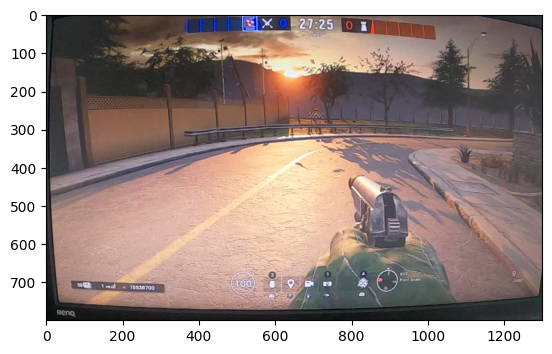

In [7]:
start_idx_x = 0
last_idx_x = 800
start_idx_y = 500
last_idx_y = 1800

top_frame_set = []
for i in range(len(frames)):
    top_frame_set.append(frames[i][start_idx_x : last_idx_x, start_idx_y : last_idx_y])

temp_img = top_frame_set[0]
plt.imshow(temp_img, cmap='gray')
plt.show()

In [11]:
# Taking boxes around these points
action_points = []
centre_idx_x = [200, 400, 600]
centre_idx_y = [200, 400, 600, 800, 1000, 1200]
size_xy = 20

old_frame = top_frame_set[0]
new_frame = top_frame_set[0]
min_ssim_values = []
for i in range(len(top_frame_set) - 10):
    old_frame = np.array(top_frame_set[i])
    new_frame = np.array(top_frame_set[i + 3])
    old_patches = []
    new_patches = []
    for j in range(len(centre_idx_x)):
        for k in range(len(centre_idx_y)):
            old_patches.append(old_frame[centre_idx_x[j] - size_xy : centre_idx_x[j] + size_xy,
                                        centre_idx_y[k] - size_xy : centre_idx_y[k] + size_xy, :])
            new_patches.append(new_frame[centre_idx_x[j] - size_xy : centre_idx_x[j] + size_xy,
                                        centre_idx_y[k] - size_xy : centre_idx_y[k] + size_xy, :])
    old_patches = np.array(old_patches)
    new_patches = np.array(new_patches)
    
    ssim_values = []
    for j in range(len(old_patches)):
        ssim_values.append(SSIM(old_patches[j], new_patches[j], channel_axis=2))
    min_ssim_values.append(np.min(ssim_values))
    # if i // 1000 == 1:
    #     break

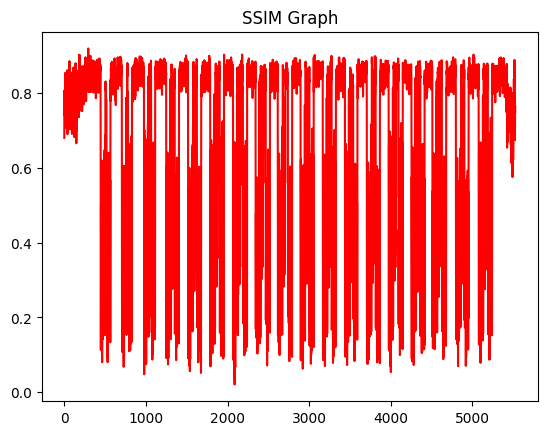

In [12]:
x = range(len(averaged_ssim_values))
y = averaged_ssim_values
plt.title("SSIM Graph")
plt.plot(y, color="red")

plt.show()

In [10]:
averaged_ssim_values

[0.5997458807881046,
 0.6698860715940537,
 0.7124223969220904,
 0.7309653569673381,
 0.6897474834130914,
 0.7273330918442088,
 0.7328251609154707,
 0.6890224980000642,
 0.674705359107788,
 0.7216958705196568,
 0.7920392589264575,
 0.7716768901210121,
 0.7710896690539452,
 0.7129001439523432,
 0.7063497420082436,
 0.7583120231402948,
 0.7312365484664295,
 0.7241840927407845,
 0.717063308220513,
 0.6999918943668374,
 0.7161691442587657,
 0.6401048131021531,
 0.70368204049671,
 0.69029955020378,
 0.7703591057002169,
 0.7429812085152463,
 0.7514839201188738,
 0.7305909648588633,
 0.6950888961441984,
 0.7062185417812653,
 0.6959592413579087,
 0.7802551489101738,
 0.7198483955839613,
 0.653601347052681,
 0.7046956878042662,
 0.8032040631671289,
 0.7484062773548064,
 0.6990224482692305,
 0.7264199458292353,
 0.7858742740295536,
 0.7893714482903077,
 0.7521225207218655,
 0.7149513150085834,
 0.6839899504482015,
 0.6514909677839525,
 0.7391078995589581,
 0.739751262673325,
 0.7672931580980259,
